In [49]:
import sys
!{sys.executable} -m pip install imblearn
import sys
!{sys.executable} -m pip install joblib

The set up

In [1]:
import pandas as pd
import sklearn as sk
import sklearn.ensemble as ens
import sklearn.metrics as metrics
import re
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_validate
from sklearn.utils.class_weight import compute_sample_weight 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier 


In [3]:
# extract the training label predictions
raw_training_data = pd.read_csv('TRAIN.csv')
training_labels = raw_training_data['rating']

# extract the validation label predictions
raw_validation_data = pd.read_csv('VALIDATION.csv')
validation_labels = raw_validation_data['rating']

# extract the validation label predictions
embedded_validation_data = pd.read_csv('384EMBEDDINGS_VALIDATION.csv')
embedded_validation_data.drop(columns=embedded_validation_data.columns[0],axis=1,inplace=True)


# get the SBERT embedded text
embedded_training_df = pd.read_csv('384EMBEDDINGS_TRAIN.csv')
embedded_training_df.drop(columns=embedded_training_df.columns[0],axis=1,inplace=True)



embedded_testing_df = pd.read_csv('384EMBEDDINGS_TEST.csv')
embedded_testing_df.drop(columns=embedded_testing_df.columns[0],axis=1,inplace=True)
raw_testing_df = pd.read_csv('TEST_NO_LABELS.csv')


run for baseline model classification report

In [156]:
dummy_most_freq = DummyClassifier()
dummy_most_freq.fit(raw_training_data,training_labels)
dummy_predictions = dummy_most_freq.predict(raw_validation_data)
print(metrics.classification_report(dummy_predictions,validation_labels))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.73      0.85      5500

    accuracy                           0.73      5500
   macro avg       0.50      0.37      0.42      5500
weighted avg       1.00      0.73      0.85      5500



C:\Users\olism\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olism\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\olism\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [230]:
"""The goal of this section is to create a decsion tree classifier for the SBERT data with parameter tuning
grid search will be applied to tree depth and min samples leaf, furthermore, we will balance the classes"""

param_grid = {'max_depth':[10,20,50,100],'min_impurity_decrease':[0.00005,0.0001,0.001,0.01], 'min_samples_leaf':[1,2,4,10,20]}
"""The parameters we should search over: tree depth, min samples leaf"""
balanced_tree = DecisionTreeClassifier(class_weight=class_weights)
gs_tree = GridSearchCV(balanced_tree,param_grid=param_grid)
dump(gs_tree.fit(embedded_training_df,training_labels),'tree_gs')


[1.77273477 0.69642741]


['tree_gs']

In [239]:
print(load('tree_gs'))
gs_results = load('tree_gs')
print(gs_results.best_params_)
best_params = gs_results.best_params_
optimal_tree = DecisionTreeClassifier(class_weight=class_weights,**best_params)
bal_tree_model = optimal_tree.fit(embedded_training_df,training_labels)



GridSearchCV(estimator=DecisionTreeClassifier(class_weight={-1: 1.7727347679116168,
                                                            1: 0.6964274146531062}),
             param_grid={'max_depth': [10, 20, 50, 100],
                         'min_impurity_decrease': [5e-05, 0.0001, 0.001, 0.01],
                         'min_samples_leaf': [1, 2, 4, 10, 20]})
{'max_depth': 100, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 2}


In [240]:
dump(bal_tree_model,'bal_tree_model')
print(metrics.classification_report(bal_tree_model.predict(embedded_validation_data),validation_labels))

              precision    recall  f1-score   support

          -1       0.79      0.63      0.70      1815
           1       0.84      0.92      0.87      3685

    accuracy                           0.82      5500
   macro avg       0.81      0.77      0.79      5500
weighted avg       0.82      0.82      0.82      5500



Run these three cells to see the classification report for random forest

In [157]:
"""This is for training a random forest model"""
# instantiate the random forest object
random_forest_for_embedded = sk.ensemble.RandomForestClassifier(n_estimators=100,class_weight='balanced',min_impurity_decrease=0.00001,min_samples_leaf=2)
# train the model
random_forest_model = random_forest_for_embedded.fit(embedded_training_df, training_labels)
dump(random_forest_model,'random_forest_model.joblib')




['random_forest_model.joblib']

In [160]:
load_random_forest_model = load('random_forest_model.joblib')
# predict
random_forest_predictions = load_random_forest_model.predict(embedded_validation_data)
   

In [161]:
# get classification report 
random_forest_classification_report = metrics.classification_report(random_forest_predictions, validation_labels)
print(random_forest_classification_report)
        

              precision    recall  f1-score   support

          -1       0.78      0.80      0.79      1430
           1       0.93      0.92      0.93      4070

    accuracy                           0.89      5500
   macro avg       0.86      0.86      0.86      5500
weighted avg       0.89      0.89      0.89      5500



The next two cells produce the classification report and confusion matrix for Naive bayes

In [162]:

# create a Naive Bayes model as described by Greaves et al without prior polarity because of resource constraints 
greaves_training_df = raw_training_data

from imblearn.under_sampling import RandomUnderSampler
rs = RandomUnderSampler(random_state=0)
greaves_training_series, training_labels_resampled = rs.fit_resample(greaves_training_df,training_labels)
print(greaves_training_series)
# convert text to lower case
greaves_training_series = greaves_training_series['review-text-cleaned'].apply(str.lower)



text_list = [(lambda text: re.sub(r'[^\w\s]','',text))(text) for text in greaves_training_series]




# create bag of words
count_vectorizer = CountVectorizer(ngram_range=(1,3),max_features=15000)
count_vectorizer.fit(text_list)
BOW_transformer = count_vectorizer.fit(text_list)
BOW_reduced = BOW_transformer.transform(text_list)

# select the 5000 best features using information gain
BOW_reducer = SelectKBest(mutual_info_classif,k=10000).fit(BOW_reduced, training_labels_resampled)
reduced_BOW = BOW_reducer.transform(BOW_reduced)
# create multinomial naive bayes model
multinomialNB = MultinomialNB()
MNB_model = multinomialNB.fit(reduced_BOW, training_labels_resampled)






       Unnamed: 0  dr-id-adjusted  dr_id_gender  \
0               7               2           1.0   
1               8               3           0.0   
2              17               7           1.0   
3              20               8           1.0   
4              24              11           1.0   
...           ...             ...           ...   
24253       19769           14204           1.0   
24254        7690            4766           0.0   
24255       21138           15668           1.0   
24256       33518           25442           1.0   
24257        6768            4221           1.0   

                                     review-text-cleaned  rating  
0      I have been to this doctor twice and both time...      -1  
1      I had the absolute worst experience with this ...      -1  
2      He was horrible! I brought my daughter in with...      -1  
3      He did surgery on my father after he started t...      -1  
4      When I was a child, he was able to correct my

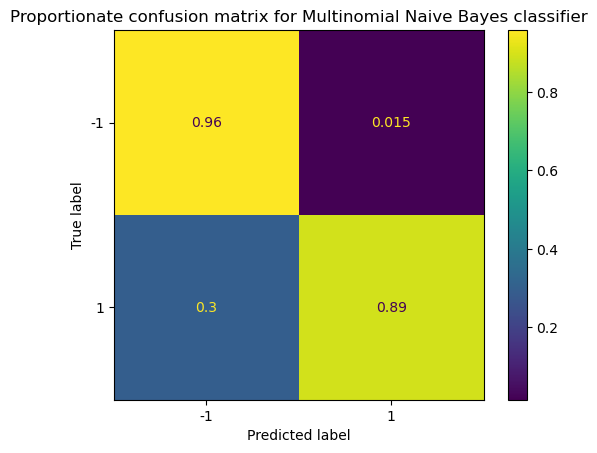

              precision    recall  f1-score   support

          -1       0.96      0.76      0.85      1835
           1       0.89      0.98      0.94      3665

    accuracy                           0.91      5500
   macro avg       0.92      0.87      0.89      5500
weighted avg       0.91      0.91      0.91      5500



In [163]:
# we need to process the validation data in the same way inorder to test the model 

# convert all text to lower case 
greaves_validation_series = raw_validation_data['review-text-cleaned'].apply(str.lower)
# remove punctuation 
validation_text_list = [re.sub(r'[^\w\s]','',text) for text in greaves_validation_series]
# use same countVectorizer 
vectors = count_vectorizer.transform(validation_text_list)
# use the previously fitted selection model to reduce the BOW
reduced_vectors = BOW_reducer.transform(vectors)
# test the model
MNB_predictions = MNB_model.predict(reduced_vectors)
# print the classification report
classification_report_greaves = metrics.classification_report(MNB_predictions, validation_labels)
cm1 = confusion_matrix(validation_labels,MNB_predictions)
cm1 = cm1/cm1.astype(float).sum(axis=1)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=MNB_model.classes_)
cmd.plot()
plt.title("Proportionate confusion matrix for Multinomial Naive Bayes classifier")
plt.show()
print(classification_report_greaves)

In [79]:
greaves_testing_df = raw_testing_df
greaves_testing_series = greaves_testing_df['review-text-cleaned'].apply(str.lower)
test_text_list = [(lambda test_text: re.sub(r'[^\w\s]','',test_text))(test_text) for test_text in greaves_testing_series]
testing_BOW_reduced_by_Count = BOW_transformer.transform(test_text_list)
k_best_BOW_test = BOW_reducer.transform(testing_BOW_reduced_by_Count)                                        
predictions = pd.DataFrame(MNB_model.predict(k_best_BOW_test))
predictions.rename_axis(index='id',columns=['rating'])
print(predictions)
predictions.to_csv('predictions')

      0
0     1
1     1
2    -1
3     1
4     1
...  ..
5509 -1
5510  1
5511  1
5512 -1
5513  1

[5514 rows x 1 columns]


This cell creates the classification report for logistic regression 

In [164]:
# implement logstic regression for embeddings
logstic_regression_instance_for_embeddings = LogisticRegression(class_weight='balanced',max_iter=100)
embeddings_log_regression_model = logstic_regression_instance_for_embeddings.fit(embedded_training_df,training_labels)

log_predictions = embeddings_log_regression_model.predict(embedded_validation_data)
print(metrics.classification_report(log_predictions,validation_labels))

              precision    recall  f1-score   support

          -1       0.94      0.77      0.85      1804
           1       0.90      0.98      0.93      3696

    accuracy                           0.91      5500
   macro avg       0.92      0.87      0.89      5500
weighted avg       0.91      0.91      0.91      5500



In [39]:
# tune the log regression
param_grid = {'max_iter': [50,70]}
gs = GridSearchCV(
    logstic_regression_instance_for_embeddings,
    param_grid,
    cv=3
                 )
dump(gs.fit(embedded_training_df,training_labels),'gs_logr.joblib')


C:\Users\olism\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\olism\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

['gs_logr.joblib']

In [41]:
gs_lr_results = load('gs_logr.joblib')
print(gs_lr_results.best_params_)

{'max_iter': 70}


only need first and third knn cell to see result

In [208]:
# we are going to have to create a new validation dataset for KNN hyperparameter selection
X_train,X_validate,y_train,y_validate = train_test_split(
    embedded_training_df, training_labels, random_state=42
)

In [ ]:
# implement KNN for embeddings


# train knn for k = 1 to k = 30
knn_error_rates = []
K = 31
for k in range(1,K):
    # get instance
    knn_instance = KNeighborsClassifier(n_neighbors=k,metric='cosine')
    # train instance
    knn_model = knn_instance.fit(X_train, y_train)
    # get predictions
    knn_predictions = knn_model.predict(X_validate)
    knn_error_rates.append(1-accuracy_score(y_validate,knn_predictions))
xpoints = np.array([x for x in range(1,K)])
ypoints = knn_error_rates
plt.plot(xpoints,ypoints)
plt.show()
    

In [169]:
min_error = min(knn_error_rates)
optimal_k = knn_error_rates.index(min_error) + 1
print("The best k: " + str(optimal_k) + " produces an error of " + str(min_error)) 
optimal_knn_instance = KNeighborsClassifier(n_neighbors=12,metric='cosine')
optimal_knn_model = optimal_knn_instance.fit(X_train,y_train)
optimal_knn_predictions = optimal_knn_instance.predict(embedded_validation_data)
print(metrics.classification_report(optimal_knn_predictions, validation_labels))

The best k: 12 produces an error of 0.11552413728955446
              precision    recall  f1-score   support

          -1       0.73      0.83      0.78      1292
           1       0.95      0.91      0.93      4208

    accuracy                           0.89      5500
   macro avg       0.84      0.87      0.85      5500
weighted avg       0.90      0.89      0.89      5500



Run the next cells to see MLP results, except the second cell, it is unecessary

In [209]:
# undersample the data
from imblearn.under_sampling import RandomUnderSampler
rs = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rs.fit_resample(embedded_training_df,training_labels)
NN_instance = MLPClassifier(max_iter=2000)

In [ ]:

# 386,258,174
hidden_layers = [[258,174],[[100,100,100,50]]]
alphas = [np.power(10.0, i) for i in range(-3,2)]

gs_nn = GridSearchCV(
    param_grid={'max_iter':[500,1000],'alpha': alphas,'hidden_layer_sizes':hidden_layers},
    estimator=NN_instance,
    cv=3,
    n_jobs=2,
    verbose=1
)

dump(gs_nn.fit(X_resampled,y_resampled),'gsNN.joblib')

In [276]:
NNgs_result = load('gsNN.joblib')
best_params = NNgs_result.best_params_
print(best_params)
NN_model = MLPClassifier(max_iter=2000,alpha=1,hidden_layer_sizes=[100,100,100,50],learning_rate='invscaling',verbose=True)
fitted_NN = NN_model.fit(embedded_training_df,training_labels)
dump(fitted_NN,'NN_model_fitted.joblib')

{'alpha': 1.0, 'hidden_layer_sizes': [258, 174], 'max_iter': 1000}
Iteration 1, loss = 0.61246502
Iteration 2, loss = 0.27929063
Iteration 3, loss = 0.26543288
Iteration 4, loss = 0.25837942
Iteration 5, loss = 0.25235519
Iteration 6, loss = 0.25280845
Iteration 7, loss = 0.25681337
Iteration 8, loss = 0.25086868
Iteration 9, loss = 0.24891273
Iteration 10, loss = 0.24797996
Iteration 11, loss = 0.25027719
Iteration 12, loss = 0.24771748
Iteration 13, loss = 0.24694056
Iteration 14, loss = 0.25111389
Iteration 15, loss = 0.25693107
Iteration 16, loss = 0.24667985
Iteration 17, loss = 0.24766351
Iteration 18, loss = 0.24754472
Iteration 19, loss = 0.24630170
Iteration 20, loss = 0.24746715
Iteration 21, loss = 0.24517180
Iteration 22, loss = 0.24472157
Iteration 23, loss = 0.24746615
Iteration 24, loss = 0.24595340
Iteration 25, loss = 0.24437762
Iteration 26, loss = 0.24573658
Iteration 27, loss = 0.24942423
Iteration 28, loss = 0.24458872
Iteration 29, loss = 0.24403532
Iteration 30, 

['NN_model_fitted.joblib']

In [277]:
NN_predictions = fitted_NN.predict(embedded_validation_data)
print(metrics.classification_report(NN_predictions,validation_labels))

              precision    recall  f1-score   support

          -1       0.90      0.80      0.85      1634
           1       0.92      0.96      0.94      3866

    accuracy                           0.92      5500
   macro avg       0.91      0.88      0.90      5500
weighted avg       0.91      0.92      0.91      5500



In [ ]:
scorers = {
    'accuracy':'accuracy',
    'f1_macro':'f1_macro',
    'precision_macro':'precision_macro',
    'recall_macro':'recall_macro'
          }
print(cross_validate())


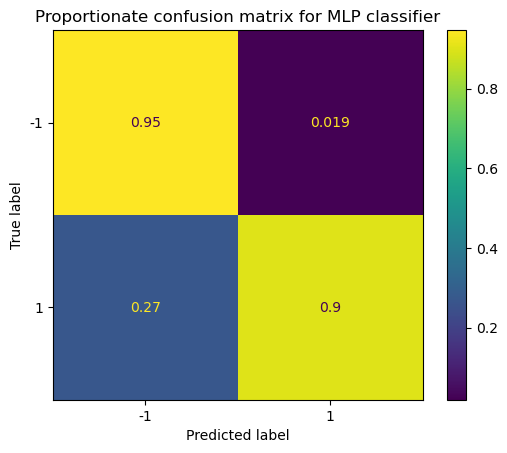

In [242]:

nn_predictions = NN_model.predict(embedded_testing_df)
nn_predictions_df = pd.DataFrame(nn_predictions)
nn_predictions_df.to_csv('nn_predictions.csv')
cm1 = confusion_matrix(validation_labels,NN_predictions)
cm1 = cm1/cm1.astype(float).sum(axis=1)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=NN_model.classes_)
cmd.plot()
plt.title("Proportionate confusion matrix for MLP classifier")
plt.show()